In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score, silhouette_score
from itertools import cycle
import joblib

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [ ]:
# Run this ONLY IF Yellowbrick shows "findfont" errors

import matplotlib.font_manager
plt.rcParams['font.family'] = 'DejaVu Sans'

In [ ]:
def combine_features(*arrays):
    return np.hstack(arrays)


In [ ]:
DPPpath = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/'
def load_feature_set(path):

    # Load preprocessed features
    df_tfidf = pd.read_pickle(DPPpath + 'features_tfidf.pkl')
    df_bow = pd.read_pickle(DPPpath + 'features_bow.pkl')
    df_lda = pd.read_pickle(DPPpath + 'features_lda.pkl')
    df_wv = pd.read_pickle(DPPpath + 'features_word2vec.pkl')

    # Prepare data
    labels = df_tfidf['label']
    numeric_labels = df_tfidf['label_num'].values
    classes = np.unique(numeric_labels)
    from sklearn.preprocessing import label_binarize
    y_binarized = label_binarize(numeric_labels, classes=classes)

    # Feature matrices (drop label columns)
    X_tfidf = df_tfidf.drop(['label', 'label_num'], axis=1).values
    X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
    X_lda = df_lda.drop(['label', 'label_num'], axis=1).values
    X_wv = df_wv.drop(['label', 'label_num'], axis=1).values

    feature_sets = {
        'TF-IDF': X_tfidf,
        'BoW': X_bow,
        'LDA': X_lda,
        'Word2Vec': X_wv,
        'TF-IDF + LDA': combine_features(X_tfidf, X_lda),
        'BoW + LDA': combine_features(X_bow, X_lda)
    }

    return labels, numeric_labels, feature_sets

In [ ]:

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
def align_cluster_labels(true_labels, pred_labels):

    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_map = {pred: true for true, pred in zip(row_ind, col_ind)}
    aligned_labels = np.array([label_map[p] for p in pred_labels])
    return aligned_labels

In [ ]:
from sklearn.manifold import TSNE
from scipy.sparse import issparse

def plot_clusters(X, labels, method_name):
    """Visualize clusters using t-SNE"""
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray() if issparse(X) else X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
    plt.title(f'{method_name} Clustering (t-SNE visualization)')
    plt.colorbar(scatter)
    plt.show()

In [ ]:
def hdbscan_clustering(X, actual_y, reduced_dim=None, min_cluster_size=5, min_samples=None, vect_path="", raw_path=""):
    # --- Perform Clustering using sklearn's HDBSCAN ---

    if reduced_dim:
        pca = PCA(n_components=reduced_dim, random_state=42)
        X = pca.fit_transform(X)

    model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    cluster_labels = model.fit_predict(X)


    # Handle noise points (-1 labels)
    noise_mask = (cluster_labels == -1)
    if noise_mask.any():
        print(f"Note: {noise_mask.sum()} points labeled as noise (-1) by HDBSCAN.")
        #assign a new cluster ID for noise if needed
        max_label = cluster_labels.max()
        cluster_labels[noise_mask] = max_label + 1

    # Align cluster labels to actual labels
    aligned_labels = align_cluster_labels(actual_y, cluster_labels)

    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(actual_y, aligned_labels)
    print(f"Cohen's Kappa (after alignment): {kappa:.3f}")

    # --- Coherence Score Calculation (if paths are provided) ---
    if vect_path and raw_path and not reduced_dim:
        vectorizer = joblib.load(vect_path)
        doc_raw = pd.read_pickle(raw_path)
        documents = doc_raw['text'].astype(str).tolist()

        top_words = []
        for cluster in range(aligned_labels.max() + 1):
            cluster_mask = (aligned_labels == cluster)
            cluster_docs = X[cluster_mask]
            if issparse(cluster_docs):
                cluster_docs = cluster_docs.toarray()
            if cluster_docs.shape[0] == 0:
                top_words.append([])
                continue
            centroid = np.mean(cluster_docs, axis=0)
            top_indices = centroid.argsort()[-10:][::-1]
            top_words.append([vectorizer.get_feature_names_out()[i] for i in top_indices])

        coherence_model = CoherenceModel(
            topics=top_words,
            texts=[doc.split() for doc in documents],
            dictionary=Dictionary([doc.split() for doc in documents]),
            coherence='c_v'
        )
        print(f"Coherence Score: {coherence_model.get_coherence():.3f}")

    # --- Plot Cluster Distribution (Aligned) ---
    df = pd.DataFrame({'Actual': actual_y, 'Cluster': aligned_labels})
    counts = df.groupby(['Actual', 'Cluster']).size().unstack()

    counts.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title('Distribution of Actual Labels Across Clusters (Aligned)')
    plt.ylabel('Count')
    plt.xlabel('Actual Label')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    return aligned_labels

In [ ]:

rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_tfidf.pkl'
labels, numeric_labels, feat = load_feature_set(DPPpath)

Note: 730 points labeled as noise (-1) by HDBSCAN.
Cohen's Kappa (after alignment): 0.168


/tmp/ipykernel_1786/2604344860.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


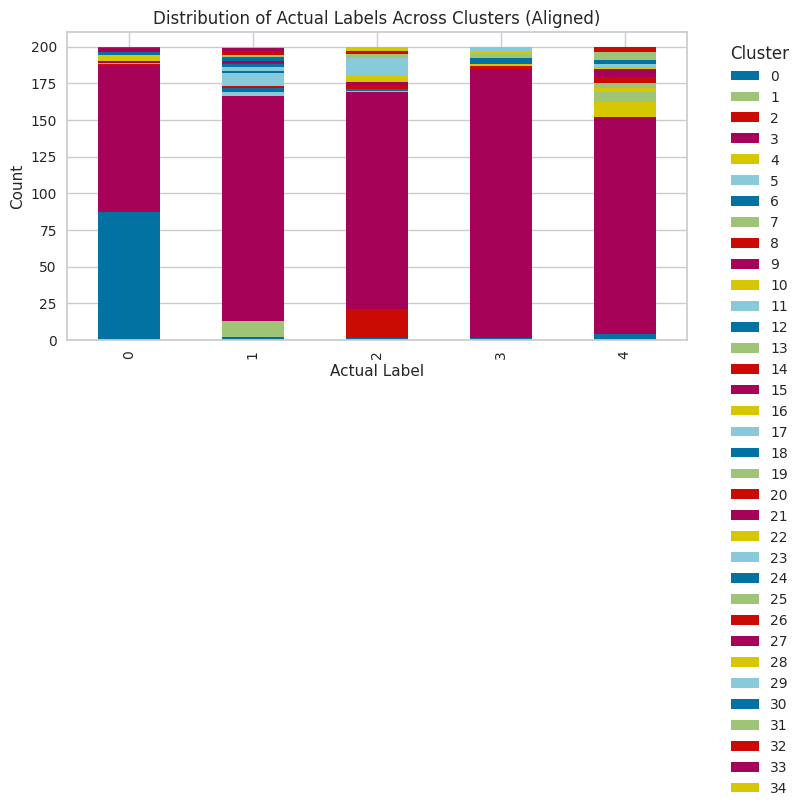

In [ ]:
labelset = spectral_clustering(feat['TF-IDF'], numeric_labels, 5, vect_path = vecpath, raw_path = rawpath)

Note: 1000 points labeled as noise (-1) by HDBSCAN.
Cohen's Kappa (after alignment): 0.000
Coherence Score: 0.390


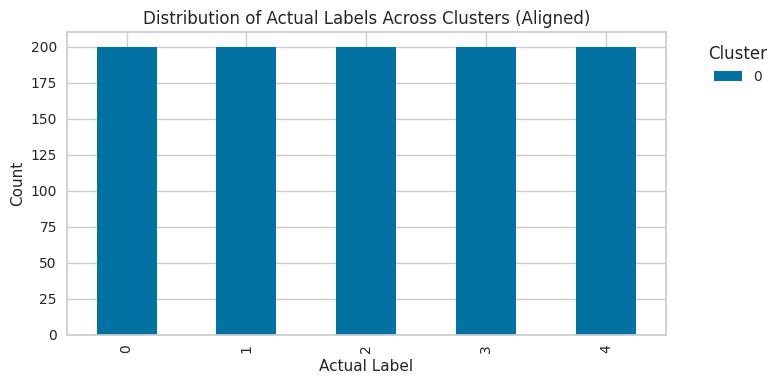

In [ ]:

rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_bow.pkl'
labels, numeric_labels, feat = load_feature_set(DPPpath)
tru = hdbscan_clustering(feat['BoW'], numeric_labels, min_cluster_size=5, vect_path = vecpath, raw_path = rawpath)

Note: 52 points labeled as noise (-1) by HDBSCAN.
Cohen's Kappa (after alignment): 0.020


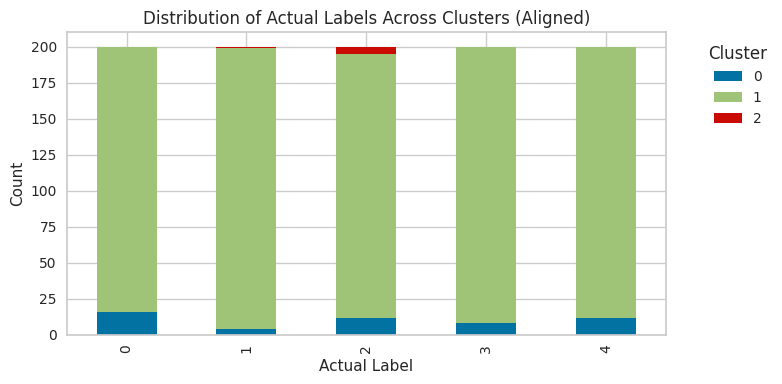

In [ ]:

rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_bow.pkl'
labels, numeric_labels, feat = load_feature_set(DPPpath)
tru = hdbscan_clustering(feat['Word2Vec'], numeric_labels, min_cluster_size=6)